In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util import *
from numpy.linalg import norm

# Note: for this simple robot, linear interpolation between (i-1) and (i+1)
#       is a good alternative for the mass center interpolation.

# Get initial path from ik solution

In [2]:
# define path to follow
Np = 8
xp = np.vstack((np.linspace(-1.5, 1.5, Np),
                np.ones(Np) * 1.0
              )).T

In [3]:
qp = np.array([[ 2.10575748,  0.895666  ],
 [ 1.64228905,  1.49674909],
 [ 1.20786201,  1.8685436 ],
 [ 0.74784918,  2.06808096],
 [ 0.32566251,  2.06808096],
 [ 0.06518705,  1.8685436 ],
 [ 0.00255452,  1.49674909],
 [ 0.14017021,  0.89566479]])


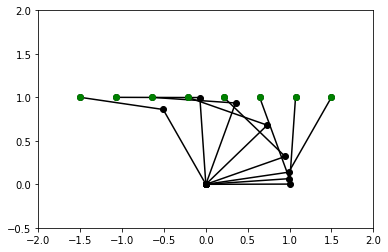

In [4]:
plt.figure()
plt.axis([-2, 2, -0.5, 2])
for j in range(len(qp)):
    x2, x1 = fk(qp[j], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'ko-')
plt.plot(xp[:, 0], xp[:, 1], 'go')
plt.show()

# Trajectory shortening

In [5]:
def trajectory_shortening(xp, qp, delta, zeta=0.001, angle_max=0.5):
    # check xp shape and length
    if xp.shape[1] != 2:
        raise ValueError("Input path must have shape 2 x N")       
    Np = xp.shape[0]
    
    qsol = [qp[0]]
    xsol = [xp[0]]
    
    for i in range(1, Np-1):
        # save current piont
        qi = qp[i]
        xi = xp[i]
        
        # create joint space vectors
        v1 = qp[i-1] - qp[i]
        v2 = qp[i+1] - qp[i]
        nv1 = norm(v1)
        nv2 = norm(v2)
        
        # vector must have minimum length to allow for sufficient shortening
        if (nv1 < zeta) or (nv2 < zeta):
            qsol.append(qi)
            xsol.append(xi)
            continue
        
        # If angle is big, not much shortening can be done
        angle12 = abs(angle(v1, v2, nv1, nv2))
        print angle12
        if (angle12 > angle_max):
            qsol.append(qi)
            xsol.append(xi)
            continue
            
        # if we get to this part of the loop, we should try to shorten the trajectory
        # from (i-1) to (i+1) by replacing qi
        w = np.linspace(0.1, 4.0, 10) # try different weights
        for wi in w:
            qmc = mass_center(qp[i-1], qp[i], qp[i+1], wi)
            xmc = fk(qmc)
            if dist(xp[i], xp[i+1], xmc) < delta:
                print "point replaced in iteration " + str(i)
                # this is a good replacement point!
                qi = qmc
                xi = xmc
                break
            
        qsol.append(qi)
        xsol.append(xi)
    
    qsol.append(qp[-1])
    xsol.append(xp[-1])
    return qsol, xsol
    

In [16]:
d = 0.1
qp4, xp4 = trajectory_shortening(xp, qp, d, angle_max = (np.pi - 0.5))

2.93550472728
2.84299627181
2.7323216506
2.48789810445
point replaced in iteration 4
2.39138397938
point replaced in iteration 5
2.74963268392


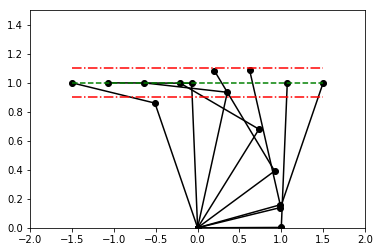

In [17]:
# plot planned motion
plt.figure()
plt.axis([-2, 2, 0.0, 1.5])

# plot solution configurations
for i in range(len(qp4)):
    x2, x1 = fk(qp4[i], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'ko-')

# given path
plt.plot(xp[:, 0], xp[:, 1], 'g--')

# allowed deviation
plt.plot(xp[:, 0], xp[:, 1] - d, 'r-.')
plt.plot(xp[:, 0], xp[:, 1] + d, 'r-.')
plt.show()